In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras.layers import Dense,Dropout,SimpleRNN,LSTM
from tensorflow.keras.models import Sequential

In [2]:
file_path = 'D:/New folder/machinelearning/projects/electricity consumption using rnn/DOM_hourly.csv'
df = pd.read_csv(file_path).set_index('Datetime')
df.head()

,DOM_MW
Datetime,
2005-12-31 01:00:00,9389.0
2005-12-31 02:00:00,9070.0
2005-12-31 03:00:00,9001.0
2005-12-31 04:00:00,9042.0
2005-12-31 05:00:00,9132.0


In [3]:
df.isna().sum()

DOM_MW    0
dtype: int64

In [4]:
df.describe()

,DOM_MW
count,116189.000000
mean,10949.203625
std,2413.946569
min,1253.000000
25%,9322.000000
50%,10501.000000
75%,12378.000000
max,21651.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 116189 entries, 2005-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   DOM_MW  116189 non-null  float64
dtypes: float64(1)
memory usage: 1.8+ MB


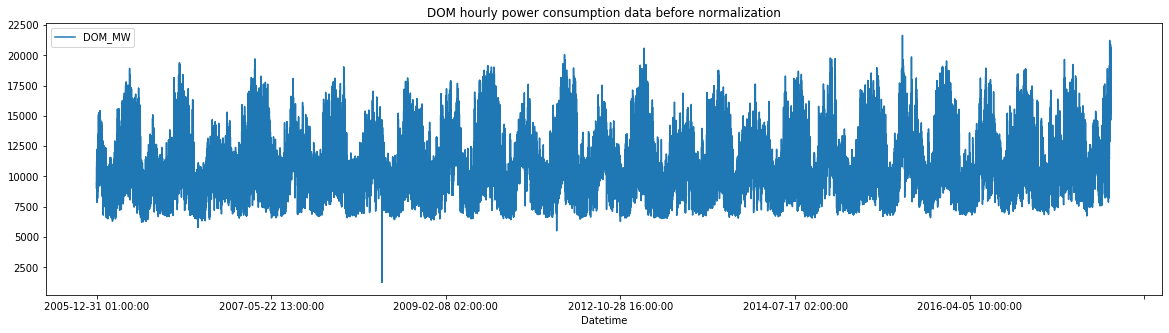

In [6]:
df.plot(figsize=(20,5),legend=True)
plt.title('DOM hourly power consumption data before normalization')
plt.show()

In [7]:
scaler = sklearn.preprocessing.MinMaxScaler()
df['DOM_MW'] = scaler.fit_transform(df['DOM_MW'].values.reshape(-1,1))
df_norm = df
df_norm.shape

(116189, 1)

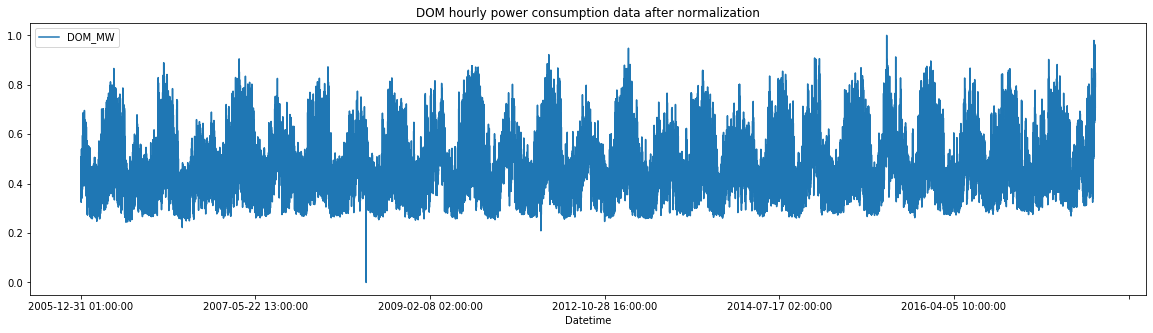

In [8]:
df_norm.plot(figsize=(20,5),legend=True)
plt.title('DOM hourly power consumption data after normalization')
plt.show()

In [9]:
df_norm.shape

(116189, 1)

In [10]:
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    #1 last 6189 days are going to be used in test
    X_test = X_train[110000:]             
    y_test = y_train[110000:]
    
    #2 first 110000 days are going to be used in training
    X_train = X_train[:110000]           
    y_train = y_train[:110000]
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (110000, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [11]:
#create train, test data
seq_len = 60 #choose sequence length

X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (110000, 60, 1)
y_train.shape =  (110000,)
X_test.shape =  (6129, 60, 1)
y_test.shape =  (6129,)


In [12]:
lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 40)            6720      
_________________________________________________________________
dropout (Dropout)            (None, 60, 40)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 40)            12960     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 40)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 4

In [13]:
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
110/110 [==============================] - 3s 28ms/step - loss: 0.0202
Epoch 2/10
110/110 [==============================] - 3s 27ms/step - loss: 0.0100
Epoch 3/10
110/110 [==============================] - 3s 27ms/step - loss: 0.0054
Epoch 4/10
110/110 [==============================] - 3s 27ms/step - loss: 0.0044
Epoch 5/10
110/110 [==============================] - 3s 27ms/step - loss: 0.0040
Epoch 6/10
110/110 [==============================] - 3s 27ms/step - loss: 0.0037
Epoch 7/10
110/110 [==============================] - 3s 27ms/step - loss: 0.0036
Epoch 8/10
110/110 [==============================] - 3s 27ms/step - loss: 0.0035
Epoch 9/10
110/110 [==============================] - 3s 27ms/step - loss: 0.0034
Epoch 10/10
110/110 [==============================] - 3s 27ms/step - loss: 0.0032


In [18]:
lstm_predictions = lstm_model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

R^2 Score of LSTM model =  0.7909432075540161


lstm_predictions = scaler.inverse_transform(lstm_predictions)
y_test = scaler.inverse_transform(y_test)

In [19]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()

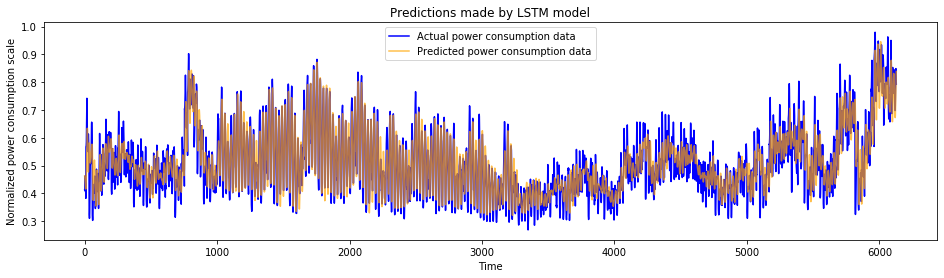

In [20]:
plot_predictions(y_test, lstm_predictions, "Predictions made by LSTM model")

In [21]:
mae= tf.keras.losses.MAE(
    y_test,lstm_predictions
)

print(mae)

tf.Tensor([0.09835348 0.09907574 0.10065935 ... 0.29233092 0.31206748 0.32739732], shape=(6129,), dtype=float32)


In [22]:
sum(mae)

<tf.Tensor: shape=(), dtype=float32, numpy=786.09503>